---

# Final Team Project: Machine Learning IoT Application Design and Implementation
## Team 1 - Jason Raimondi, Sundar Sundaresan, and Viktor Veselov
## University of San Diego
## AAI-530: Data Analytics and IoT
## Professor An Tran
## 2023-02-27

---

### GitHub Repository:
### https://github.com/SweatyCrayfish/Room-Ocupancy-Application
### Final Project - ML IoT Application.ipynb

---

### Tableau Public Dashboard:
### https://public.tableau.com/???

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew
from sklearn import preprocessing
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences

## Exploratory Data Analysis

### Load and clean data

The Room Occupancy Estimation dataset can be located in the UCI Machine Learning Repository:
https://archive.ics.uci.edu/ml/datasets/Room+Occupancy+Estimation

First, we will read the dataset from a CSV file and assign to a Pandas dataframe.  Then, we will perform some initial discovery to start exploring and learning the dataset.

In [2]:
# create new dataframe with raw data
df_raw = pd.read_csv('Occupancy_Estimation.csv')

In [3]:
# view shape of dataframe
print ('Total rows in df_raw =', df_raw.shape[0])
print ('Total columns in df_raw =', df_raw.shape[1])

Total rows in df_raw = 10129
Total columns in df_raw = 19


In [4]:
# view dataframe head
df_raw.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


We can see that we have separate columns for Date and Time.  To support our later time-series machine learning prediction, we will plan to combine into a single Datetime column.

In [5]:
# print data types and describe data
print (df_raw.dtypes)
df_raw.describe()

Date                     object
Time                     object
S1_Temp                 float64
S2_Temp                 float64
S3_Temp                 float64
S4_Temp                 float64
S1_Light                  int64
S2_Light                  int64
S3_Light                  int64
S4_Light                  int64
S1_Sound                float64
S2_Sound                float64
S3_Sound                float64
S4_Sound                float64
S5_CO2                    int64
S5_CO2_Slope            float64
S6_PIR                    int64
S7_PIR                    int64
Room_Occupancy_Count      int64
dtype: object


,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
count,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.00000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000
mean,25.454012,25.546059,25.056621,25.754125,25.445059,26.01629,34.248494,13.220259,0.168178,0.120066,0.158119,0.103840,460.860401,-0.004830,0.090137,0.079574,0.398559
std,0.351351,0.586325,0.427283,0.356434,51.011264,67.30417,58.400744,19.602219,0.316709,0.266503,0.413637,0.120683,199.964940,1.164990,0.286392,0.270645,0.893633
min,24.940000,24.750000,24.440000,24.940000,0.000000,0.00000,0.000000,0.000000,0.060000,0.040000,0.040000,0.050000,345.000000,-6.296154,0.000000,0.000000,0.000000
25%,25.190000,25.190000,24.690000,25.440000,0.000000,0.00000,0.000000,0.000000,0.070000,0.050000,0.060000,0.060000,355.000000,-0.046154,0.000000,0.000000,0.000000
50%,25.380000,25.380000,24.940000,25.750000,0.000000,0.00000,0.000000,0.000000,0.080000,0.050000,0.060000,0.080000,360.000000,0.000000,0.000000,0.000000,0.000000
75%,25.630000,25.630000,25.380000,26.000000,12.000000,14.00000,50.000000,22.000000,0.080000,0.060000,0.070000,0.100000,465.000000,0.000000,0.000000,0.000000,0.000000
max,26.380000,29.000000,26.190000,26.560000,165.000000,258.00000,280.000000,74.000000,3.880000,3.440000,3.670000,3.400000,1270.000000,8.980769,1.000000,1.000000,3.000000


We can see that we currently have 17 total numeric features (excluding Date and Time).  For our project, we will be predicting a different feature for each machine learning model developed.  To reduce complexity of our IoT system design, we will be using average values for Temperature, Light, and Sound, which will reduce the number of columns for each of these features from 4 to 1, or from 12 to 3 when considering them all.  We will create copy of the raw data and make these changes now.

In [6]:
# create new dataframe for modifications
df = df_raw.copy()

In [7]:
# create Datetime column

# combine into a single column
df['Datetime'] = df['Date'] + ' ' + df['Time']

# convert to datetime, specify that year comes first in the format
df['Datetime'] = pd.to_datetime(df['Datetime'], yearfirst=True)

In [8]:
# print data types and describe data
print (df.dtypes)
df.head()

Date                            object
Time                            object
S1_Temp                        float64
S2_Temp                        float64
S3_Temp                        float64
S4_Temp                        float64
S1_Light                         int64
S2_Light                         int64
S3_Light                         int64
S4_Light                         int64
S1_Sound                       float64
S2_Sound                       float64
S3_Sound                       float64
S4_Sound                       float64
S5_CO2                           int64
S5_CO2_Slope                   float64
S6_PIR                           int64
S7_PIR                           int64
Room_Occupancy_Count             int64
Datetime                datetime64[ns]
dtype: object


,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count,Datetime
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1,2017-12-22 10:49:41
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1,2017-12-22 10:50:12
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1,2017-12-22 10:50:42
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1,2017-12-22 10:51:13
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1,2017-12-22 10:51:44


We can see that our Datetime column is now a datetime data type.  Let's check to see if the Date and Time columns are date and time data types.

In [9]:
df['Date'][0]

'2017/12/22'

The Date column does not appear to be a date data type.  Let's also check the Time column.

In [10]:
df['Time'][0]

'10:49:41'

The Time column does not appear to be a time data type.  Let's use our Datetime column to turn the Date and Time columns into date and time data types.

In [11]:
# convert to date and time data types
df['Date'] = df['Datetime'].dt.date
df['Time'] = df['Datetime'].dt.time

Let's now recheck our Date and Time columns to verify the data types are correct.

In [12]:
df['Date'][0]

datetime.date(2017, 12, 22)

The Date column is now a date data type.

In [13]:
df['Time'][0]

datetime.time(10, 49, 41)

The Time column is now a time data type.

Let's review the describe() results again now that we have a numeric Datetime column that can be included in the results.

In [14]:
# describe, including statistics on Datetime column
df.describe(datetime_is_numeric = True)

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count,Datetime
count,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.00000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129
mean,25.454012,25.546059,25.056621,25.754125,25.445059,26.01629,34.248494,13.220259,0.168178,0.120066,0.158119,0.103840,460.860401,-0.004830,0.090137,0.079574,0.398559,2017-12-27 20:27:23.034554112
min,24.940000,24.750000,24.440000,24.940000,0.000000,0.00000,0.000000,0.000000,0.060000,0.040000,0.040000,0.050000,345.000000,-6.296154,0.000000,0.000000,0.000000,2017-12-22 10:49:41
25%,25.190000,25.190000,24.690000,25.440000,0.000000,0.00000,0.000000,0.000000,0.070000,0.050000,0.060000,0.060000,355.000000,-0.046154,0.000000,0.000000,0.000000,2017-12-23 09:14:33
50%,25.380000,25.380000,24.940000,25.750000,0.000000,0.00000,0.000000,0.000000,0.080000,0.050000,0.060000,0.080000,360.000000,0.000000,0.000000,0.000000,0.000000,2017-12-24 07:06:45
75%,25.630000,25.630000,25.380000,26.000000,12.000000,14.00000,50.000000,22.000000,0.080000,0.060000,0.070000,0.100000,465.000000,0.000000,0.000000,0.000000,0.000000,2017-12-26 04:58:18
max,26.380000,29.000000,26.190000,26.560000,165.000000,258.00000,280.000000,74.000000,3.880000,3.440000,3.670000,3.400000,1270.000000,8.980769,1.000000,1.000000,3.000000,2018-01-11 09:00:09
std,0.351351,0.586325,0.427283,0.356434,51.011264,67.30417,58.400744,19.602219,0.316709,0.266503,0.413637,0.120683,199.964940,1.164990,0.286392,0.270645,0.893633,NaN


We can see that our IoT sensor readings start on 12/22/2017 and end on 1/11/2018.  We can also see the Room Occupany Count ranging from 0 to 3 persons.  Let's check the unique values of Date and Room Occupancy Count.

In [15]:
# print unique Dates
print ('Unique Dates: \n', df['Date'].unique(), '\n')

# print unique Room Occupancy Count
print ('Unique Room Occupancy Count: \n', df['Room_Occupancy_Count'].unique())

Unique Dates: 
 [datetime.date(2017, 12, 22) datetime.date(2017, 12, 23)
 datetime.date(2017, 12, 24) datetime.date(2017, 12, 25)
 datetime.date(2017, 12, 26) datetime.date(2018, 1, 10)
 datetime.date(2018, 1, 11)] 

Unique Room Occupancy Count: 
 [1 2 3 0]


We can see that data was not collected for every day in the entire range of dates, as there is a gap between 12/26/2017 and 1/10/2018.  We can also see that Christmas Day and days surrounding the Holiday are included, so it's possible that these were days when there was no room occupancy.  We can also see that the Room Occupancy does range from 0 to 3 occupants, as was described in the dataset source information.  Our row counts are all equal, so there does not appear to be any missing data.  We will check to be sure.

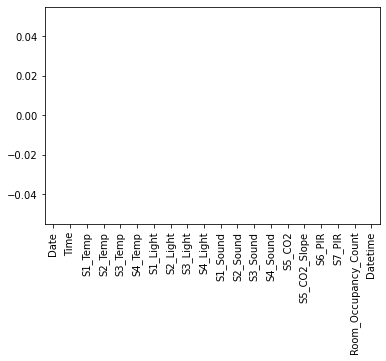

In [16]:
# Visualize any missing data
df.isna().sum().plot.bar();

The bar graph confirms that we are not missing any data.  Our IoT system is based on a single IoT device in a room, versus multiple devices that were used to generate the original dataset.  To adapt the dataset to our IoT system design, we will consolidate Temperature, Light, and Sound columns into corresponding average columns.  This will simulate these readings coming from single sensors, as in our IoT system design.  It will also reduce the complexity of the dataset.

In [17]:
# create new columns for combined (average) temperature, light, and sound
df['Temp'] = (df['S1_Temp'] + df['S2_Temp'] + df['S3_Temp'] + df['S4_Temp'] / 4)
df['Light'] = (df['S1_Light'] + df['S2_Light'] + df['S3_Light'] + df['S4_Light'] / 4)
df['Sound'] = (df['S1_Sound'] + df['S2_Sound'] + df['S3_Sound'] + df['S4_Sound'] / 4)

# view dataframe
df.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,...,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count,Datetime,Temp,Light,Sound
0,2017-12-22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,...,0.06,390,0.769231,0,0,1,2017-12-22 10:49:41,80.595,218.0,0.3450
1,2017-12-22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,...,0.06,390,0.646154,0,0,1,2017-12-22 10:50:12,80.610,217.0,1.0550
2,2017-12-22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,...,0.06,390,0.519231,0,0,1,2017-12-22 10:50:42,80.610,218.0,0.6350
3,2017-12-22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,...,0.09,390,0.388462,0,0,1,2017-12-22 10:51:13,80.670,218.0,0.6325
4,2017-12-22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,...,0.06,390,0.253846,0,0,1,2017-12-22 10:51:44,80.670,219.0,0.3150


Let's now drop the separate reading colums for temperature, light, and sound then view our dataframe again.

In [18]:
# drop individual reading columns for temperature, light, and sound
df = df.drop(columns=['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp'])
df = df.drop(columns=['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light'])
df = df.drop(columns=['S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound'])

# view dataframe
df.head()

,Date,Time,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count,Datetime,Temp,Light,Sound
0,2017-12-22,10:49:41,390,0.769231,0,0,1,2017-12-22 10:49:41,80.595,218.0,0.3450
1,2017-12-22,10:50:12,390,0.646154,0,0,1,2017-12-22 10:50:12,80.610,217.0,1.0550
2,2017-12-22,10:50:42,390,0.519231,0,0,1,2017-12-22 10:50:42,80.610,218.0,0.6350
3,2017-12-22,10:51:13,390,0.388462,0,0,1,2017-12-22 10:51:13,80.670,218.0,0.6325
4,2017-12-22,10:51:44,390,0.253846,0,0,1,2017-12-22 10:51:44,80.670,219.0,0.3150


Now, we will rename and reorder a few columns before moving forward.

In [19]:
# columns to rename
renaming = {'S5_CO2': 'CO2', 
            'S5_CO2_Slope': 'CO2_Slope', 
            'S6_PIR': 'PIR_S1', 
            'S7_PIR': 'PIR_S2',}

# rename columns in existing dataframe
df = df.rename(renaming, axis=1)

# reorder columns in existing dataframe
df = df[['Datetime', 'Date', 'Time', 'Temp', 'Light', 'Sound', 'CO2', 'CO2_Slope', 'PIR_S1', 'PIR_S2', 'Room_Occupancy_Count']]

# view dataframe
df.head()

,Datetime,Date,Time,Temp,Light,Sound,CO2,CO2_Slope,PIR_S1,PIR_S2,Room_Occupancy_Count
0,2017-12-22 10:49:41,2017-12-22,10:49:41,80.595,218.0,0.3450,390,0.769231,0,0,1
1,2017-12-22 10:50:12,2017-12-22,10:50:12,80.610,217.0,1.0550,390,0.646154,0,0,1
2,2017-12-22 10:50:42,2017-12-22,10:50:42,80.610,218.0,0.6350,390,0.519231,0,0,1
3,2017-12-22 10:51:13,2017-12-22,10:51:13,80.670,218.0,0.6325,390,0.388462,0,0,1
4,2017-12-22 10:51:44,2017-12-22,10:51:44,80.670,219.0,0.3150,390,0.253846,0,0,1


In [20]:
# describe dataframe
df.describe(datetime_is_numeric = True)

,Datetime,Temp,Light,Sound,CO2,CO2_Slope,PIR_S1,PIR_S2,Room_Occupancy_Count
count,10129,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000
mean,2017-12-27 20:27:23.034554112,82.495223,89.014908,0.472323,460.860401,-0.004830,0.090137,0.079574,0.398559
min,2017-12-22 10:49:41,80.595000,0.000000,0.165000,345.000000,-6.296154,0.000000,0.000000,0.000000
25%,2017-12-23 09:14:33,81.442500,0.000000,0.195000,355.000000,-0.046154,0.000000,0.000000,0.000000
50%,2017-12-24 07:06:45,82.152500,0.000000,0.205000,360.000000,0.000000,0.000000,0.000000,0.000000
75%,2017-12-26 04:58:18,83.007500,92.000000,0.225000,465.000000,0.000000,0.000000,0.000000,0.000000
max,2018-01-11 09:00:09,87.370000,720.250000,11.380000,1270.000000,8.980769,1.000000,1.000000,3.000000
std,NaN,1.359938,166.377263,0.856572,199.964940,1.164990,0.286392,0.270645,0.893633


No further cleaning appears to be necessary for this dataset.

### Visualizing the data

Let's create some visualizations to get a better understanding of the dataset and distribution of data.  We will start with histograms, boxplots, and violinplots.

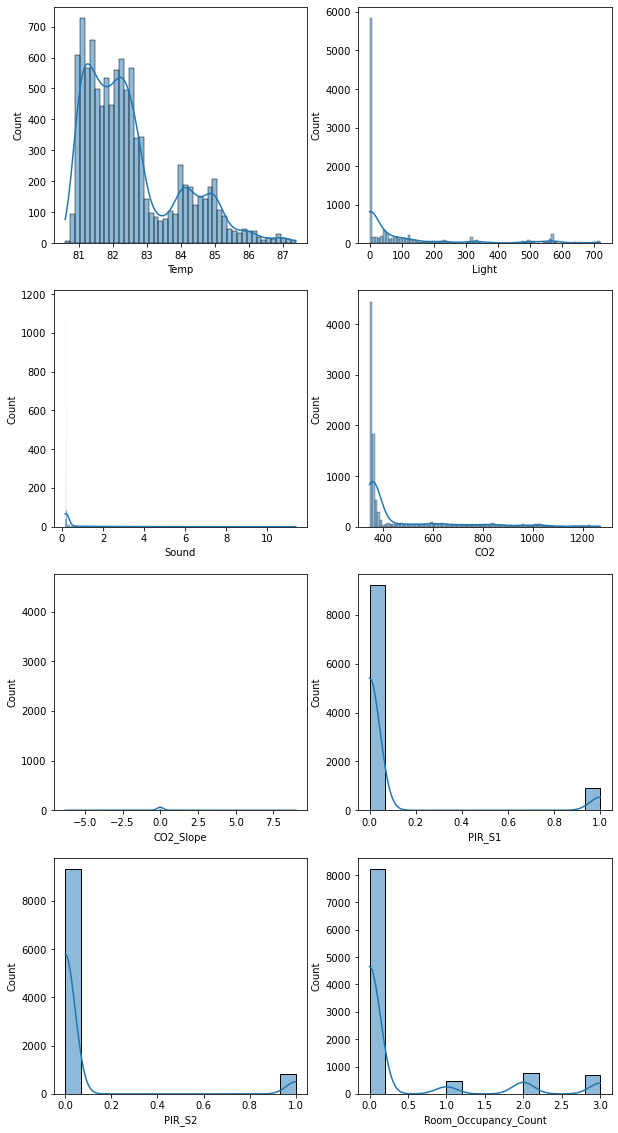

In [21]:
# create histograms for each feature
fig, axs = plt.subplots(4, 2, figsize=(10, 20))

sns.histplot(data=df, x='Temp', kde=True, ax=axs[0, 0])
sns.histplot(data=df, x='Light', kde=True, ax=axs[0, 1])
sns.histplot(data=df, x='Sound', kde=True, ax=axs[1, 0])
sns.histplot(data=df, x='CO2', kde=True, ax=axs[1, 1])
sns.histplot(data=df, x='CO2_Slope', kde=True, ax=axs[2, 0])
sns.histplot(data=df, x='PIR_S1', kde=True, ax=axs[2, 1])
sns.histplot(data=df, x='PIR_S2', kde=True, ax=axs[3, 0])
sns.histplot(data=df, x='Room_Occupancy_Count', kde=True, ax=axs[3, 1])

plt.show()

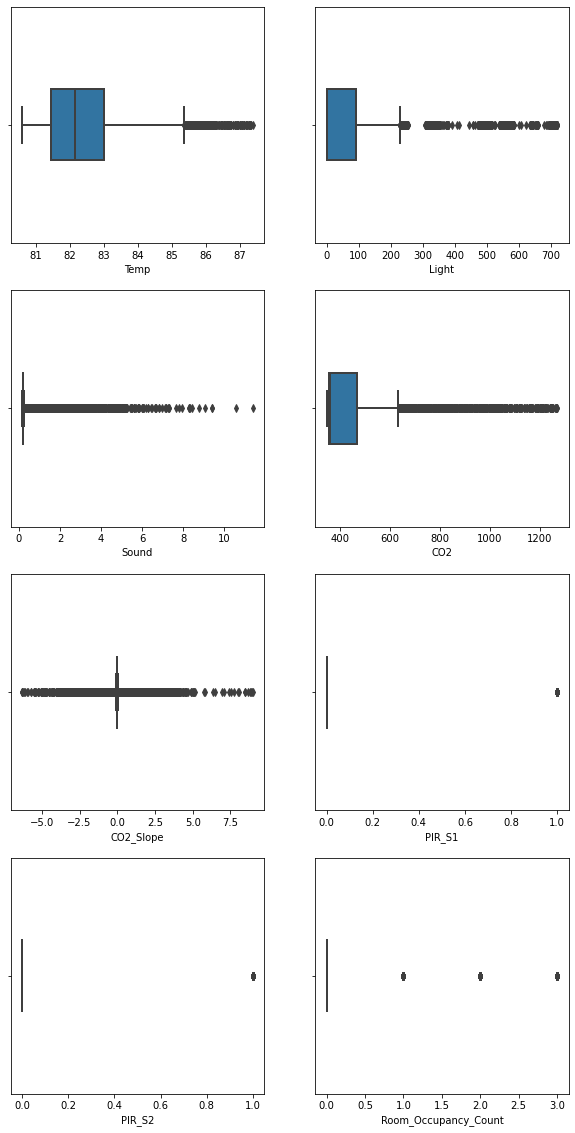

In [22]:
# create boxplots for each feature
fig, axs = plt.subplots(4, 2, figsize=(10, 20))

sns.boxplot(data=df, x='Temp', width=.3, linewidth=2, fliersize=5, ax=axs[0, 0])
sns.boxplot(data=df, x='Light', width=.3, linewidth=2, fliersize=5, ax=axs[0, 1])
sns.boxplot(data=df, x='Sound', width=.3, linewidth=2, fliersize=5, ax=axs[1, 0])
sns.boxplot(data=df, x='CO2', width=.3, linewidth=2, fliersize=5, ax=axs[1, 1])
sns.boxplot(data=df, x='CO2_Slope', width=.3, linewidth=2, fliersize=5, ax=axs[2, 0])
sns.boxplot(data=df, x='PIR_S1', width=.3, linewidth=2, fliersize=5, ax=axs[2, 1])
sns.boxplot(data=df, x='PIR_S2', width=.3, linewidth=2, fliersize=5, ax=axs[3, 0])
sns.boxplot(data=df, x='Room_Occupancy_Count', width=.3, linewidth=2, fliersize=5, ax=axs[3, 1])

plt.show()

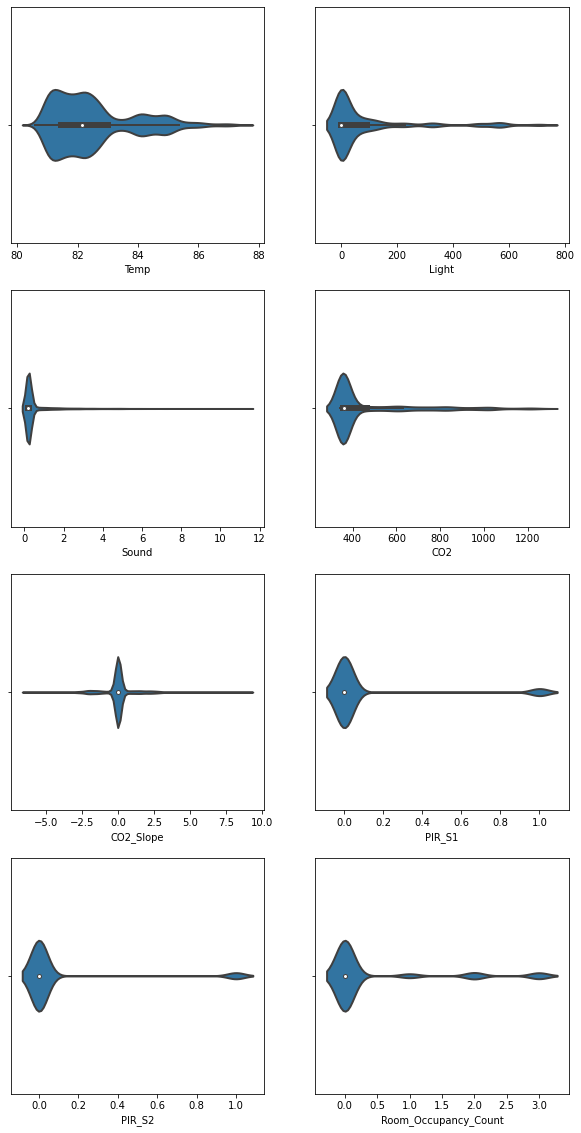

In [23]:
# create violinplots for each feature
fig, axs = plt.subplots(4, 2, figsize=(10, 20))

sns.violinplot(data=df, x='Temp', width=.3, linewidth=2, fliersize=5, showfliers=False, ax=axs[0, 0])
sns.violinplot(data=df, x='Light', width=.3, linewidth=2, fliersize=5, showfliers=False, ax=axs[0, 1])
sns.violinplot(data=df, x='Sound', width=.3, linewidth=2, fliersize=5, showfliers=False, ax=axs[1, 0])
sns.violinplot(data=df, x='CO2', width=.3, linewidth=2, fliersize=5, showfliers=False, ax=axs[1, 1])
sns.violinplot(data=df, x='CO2_Slope', width=.3, linewidth=2, fliersize=5, showfliers=False, ax=axs[2, 0])
sns.violinplot(data=df, x='PIR_S1', width=.3, linewidth=2, fliersize=5, showfliers=False, ax=axs[2, 1])
sns.violinplot(data=df, x='PIR_S2', width=.3, linewidth=2, fliersize=5, showfliers=False, ax=axs[3, 0])
sns.violinplot(data=df, x='Room_Occupancy_Count', width=.3, linewidth=2, fliersize=5, showfliers=False, ax=axs[3, 1])

plt.show()

We can see that the Room Occupancy is empty (i.e., 0) for the majority of the time readings were collected.  This explains why most of our data does not appear to be normally distributed.  Most values are skewed to the left, indicating no or low sensor readings while rooms are vacant.  We will likely need to consider data tranformations and/or normalizations prior to training our machine learning models.

We will now calculate the skewness of each feature using the ```skew``` statistical function from the ```scipy.stats``` module.

In [24]:
# calculate the skewness
Temp_skewness = skew(df['Temp'])
Light_skewness = skew(df['Light'])
Sound_skewness = skew(df['Sound'])
CO2_skewness = skew(df['CO2'])
CO2_Slope_skewness = skew(df['CO2_Slope'])
PIR_S1_skewness = skew(df['PIR_S1'])
PIR_S2_skewness = skew(df['PIR_S2'])
Room_Occupancy_Count_skewness = skew(df['Room_Occupancy_Count'])

print(f"Skewness Temp = {Temp_skewness:.2f}")
print(f"Skewness Light = {Light_skewness:.2f}")
print(f"Skewness Sound = {Sound_skewness:.2f}")
print(f"Skewness CO2 = {CO2_skewness:.2f}")
print(f"Skewness CO2_Slope = {CO2_Slope_skewness:.2f}")
print(f"Skewness PIR_S1 = {PIR_S1_skewness:.2f}")
print(f"Skewness PIR_S2 = {PIR_S2_skewness:.2f}")
print(f"Skewness Room_Occupancy_Count = {Room_Occupancy_Count_skewness:.2f}")

Skewness Temp = 1.06
Skewness Light = 2.17
Skewness Sound = 4.69
Skewness CO2 = 1.98
Skewness CO2_Slope = 0.29
Skewness PIR_S1 = 2.86
Skewness PIR_S2 = 3.11
Skewness Room_Occupancy_Count = 2.06


The results agree with our previous observation.  All features have a positvely-skewed data distribution, with the most skewed feature being Sound and the least skewed feature being CO2_Slope.

Finally, we will display a heatmap to look for the presence of multicollinearity in the features.

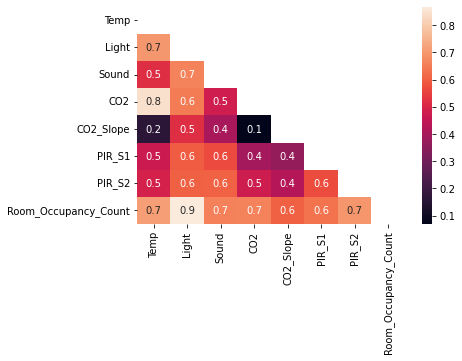

In [25]:
# find relationship between columns in form of a heat map
sns.heatmap(df.corr(), annot=True, fmt=".1f", mask=np.triu(df.corr()));

The highest correlations appear to be between Room_Occupancy_Count and Light (0.9), as well as between CO2 and Temp (0.8).

## Machine Learning Tasks

### Task 1a - Deep Learning LSTM Time Series Prediction for Room Occupancy Count

#### Load and prepare data

For our Deep Learning Long Short Term Memory (LSTM) Time Series prediction, we will begin by making a copy of our dataframe and splitting it into training and testing dataframes, using 80% for training and 20% for testing.

In [26]:
# create new copy of dataframe
df_lstm = df.copy()

In [27]:
# print shape of dataframe
print ('Shape of df_lstm is:', df_lstm.shape)

Shape of df_lstm is: (10129, 11)


In [28]:
# find location which splits df_lstm into 80% and 20%
loc_split = round((df_lstm.shape[0]*.80))

# create train_df using 80% of df_lstm
train_df = df_lstm.iloc[0:loc_split]

# create val_df using remaining 20% of df_lstm
val_df = df_lstm.iloc[loc_split:]

# reset validation dataframe index for cleanliness
val_df = val_df.reset_index()

In [29]:
# print shape of training and testing dataframes
print ('Shape of train_df is:', train_df.shape)
print ('Shape of val_df is:', val_df.shape)

Shape of train_df is: (8103, 11)
Shape of val_df is: (2026, 12)


We can see that the shapes of our training and testing dataframes reflect the 80% and 20% split.  Let's now review our training dataframe.

In [30]:
# describe dataframe
train_df.describe(datetime_is_numeric = True)

,Datetime,Temp,Light,Sound,CO2,CO2_Slope,PIR_S1,PIR_S2,Room_Occupancy_Count
count,8103,8103.000000,8103.000000,8103.000000,8103.000000,8103.000000,8103.000000,8103.000000,8103.000000
mean,2017-12-24 07:29:07.647908352,82.594069,102.635073,0.508691,469.516846,-0.003256,0.091571,0.075034,0.407874
min,2017-12-22 10:49:41,80.595000,0.000000,0.165000,350.000000,-6.296154,0.000000,0.000000,0.000000
25%,2017-12-23 04:51:51.500000,81.522500,0.000000,0.195000,355.000000,-0.046154,0.000000,0.000000,0.000000
50%,2017-12-23 22:21:52,82.242500,0.000000,0.207500,360.000000,0.000000,0.000000,0.000000,0.000000
75%,2017-12-25 15:51:44,83.165000,120.125000,0.225000,485.000000,0.026923,0.000000,0.000000,0.000000
max,2018-01-10 15:34:59,87.370000,720.250000,11.380000,1270.000000,8.980769,1.000000,1.000000,3.000000
std,NaN,1.403560,174.548592,0.925703,209.646787,1.199047,0.288437,0.263462,0.884532


We can see that the numeric features are not on similar scales.  Let's normalize using the ```MinMaxScaler``` class from ```sklearn```.  We will omit any non-numeric columns from scaling, as well as Datetime and the PIR_S1 and PIR_S2 sensors since they hold binary values.  We will also avoid scaling our output feature of Room_Occupancy_Count.

In [31]:
# MinMax normalization (from 0 to 1)

# select columns to normalize, exclude non-numeric, Datetime, PIR sensors, and output feature
cols_normalize = train_df.columns.difference(['Date', 'Time', 'Datetime', 'PIR_S1', 'PIR_S2', 'Room_Occupancy_Count'])

# scale selected columns between 0 and 1
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)

# recombine scaled columns with the training dataframe
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

# print dataframe head
train_df.head()

,Datetime,Date,Time,Temp,Light,Sound,CO2,CO2_Slope,PIR_S1,PIR_S2,Room_Occupancy_Count
0,2017-12-22 10:49:41,2017-12-22,10:49:41,0.000000,0.302673,0.016050,0.043478,0.462487,0,0,1
1,2017-12-22 10:50:12,2017-12-22,10:50:12,0.002214,0.301284,0.079358,0.043478,0.454431,0,0,1
2,2017-12-22 10:50:42,2017-12-22,10:50:42,0.002214,0.302673,0.041908,0.043478,0.446123,0,0,1
3,2017-12-22 10:51:13,2017-12-22,10:51:13,0.011070,0.302673,0.041685,0.043478,0.437563,0,0,1
4,2017-12-22 10:51:44,2017-12-22,10:51:44,0.011070,0.304061,0.013375,0.043478,0.428751,0,0,1


In [32]:
# describe dataframe
train_df.describe(datetime_is_numeric = True)

,Datetime,Temp,Light,Sound,CO2,CO2_Slope,PIR_S1,PIR_S2,Room_Occupancy_Count
count,8103,8103.000000,8103.000000,8103.000000,8103.000000,8103.000000,8103.000000,8103.000000,8103.000000
mean,2017-12-24 07:29:07.647908352,0.295066,0.142499,0.030646,0.129910,0.411922,0.091571,0.075034,0.407874
min,2017-12-22 10:49:41,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017-12-23 04:51:51.500000,0.136900,0.000000,0.002675,0.005435,0.409114,0.000000,0.000000,0.000000
50%,2017-12-23 22:21:52,0.243173,0.000000,0.003790,0.010870,0.412135,0.000000,0.000000,0.000000
75%,2017-12-25 15:51:44,0.379336,0.166782,0.005350,0.146739,0.413897,0.000000,0.000000,0.000000
max,2018-01-10 15:34:59,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000
std,NaN,0.207168,0.242344,0.082542,0.227877,0.078487,0.288437,0.263462,0.884532


All of our sensor colums now show values between 0 and 1, as seen by looking at the min and max values of each.

Before building our model, we will create a nested list structure for the training data, using a sequence of Temperature readings as the input and the Room Occupancy Count at our prediction horizon as the expected output.

In [33]:
# define sequence length and prediction horizon
seq_length = 25
ph = 1

# pick the feature columns 
feat_cols = ['Temp']

# create nested list structure
seq_arrays = []
seq_labs = []

# create list of sequence length temperature readings
rlen = len(train_df) - seq_length - ph
for start in range(0, rlen):
    seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['Room_Occupancy_Count'].iloc[start:start+seq_length+ph].to_numpy()[-1]])
    
#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [34]:
# assert statements to verify we have our expected array shapes
assert(seq_arrays.shape == (len(train_df)-seq_length-ph, seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph, 1))

In [35]:
# print shape of sequence arrays and sequence labels
print ('Shape of seq_arrays is:', seq_arrays.shape)
print ('Shape of seq_labs is:', seq_labs.shape)

Shape of seq_arrays is: (8077, 25, 1)
Shape of seq_labs is: (8077, 1)


Our sequence arrays are the shapes we expect.  They both have 8077 instances, and the seq_arrays shape reflects the seq_length we defined earlier.

#### Model Training

We will now build our Deep Learning Learning LSTM Time Series Prediction model.  This will be a sequential model with two LSTM layers, using a linear activation function and including dropout to prevent overtraining.

In [36]:
# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]

# create sequential model object
model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5, 
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.005)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

# print model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 5)             140       
                                                                 
 dropout (Dropout)           (None, 25, 5)             0         
                                                                 
 lstm_1 (LSTM)               (None, 3)                 108       
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 252
Trainable params: 252
Non-trainable pa

For our LSTM model, we can see that the LSTM and Dropout output shapes align with the hidden units we defined for each layer.  Our dense layer outputs one value, which is our prediction for Room Occupancy Count.  To tune the model, we decided to set a low value for the model's learning rate.  Additionally, we will adjust batch size while fitting the model, as well as the patience argument for early stopping.  In our experimentation with tuning, we find that allowing for additional epochs before stopping results in a more accurate model.  Let's now fit our model and plot the resulting Mean Squared Error (MSE) and loss.

In [37]:
# fit the model
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=125, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Epoch 1/100
62/62 - 4s - loss: 0.5592 - mse: 0.5592 - val_loss: 0.3593 - val_mse: 0.3593 - 4s/epoch - 57ms/step
Epoch 2/100
62/62 - 1s - loss: 0.4020 - mse: 0.4020 - val_loss: 0.3555 - val_mse: 0.3555 - 550ms/epoch - 9ms/step
Epoch 3/100
62/62 - 1s - loss: 0.4242 - mse: 0.4242 - val_loss: 0.3265 - val_mse: 0.3265 - 527ms/epoch - 8ms/step
Epoch 4/100
62/62 - 1s - loss: 0.3992 - mse: 0.3992 - val_loss: 0.3529 - val_mse: 0.3529 - 506ms/epoch - 8ms/step
Epoch 5/100
62/62 - 1s - loss: 0.3942 - mse: 0.3942 - val_loss: 0.3515 - val_mse: 0.3515 - 548ms/epoch - 9ms/step
Epoch 6/100
62/62 - 1s - loss: 0.3911 - mse: 0.3911 - val_loss: 0.3833 - val_mse: 0.3833 - 517ms/epoch - 8ms/step
Epoch 7/100
62/62 - 1s - loss: 0.3859 - mse: 0.3859 - val_loss: 0.3928 - val_mse: 0.3928 - 541ms/epoch - 9ms/step
Epoch 8/100
62/62 - 1s - loss: 0.3620 - mse: 0.3620 - val_loss: 0.3924 - val_mse: 0.3924 - 524ms/epoch - 8ms/step
Epoch 9/100
62/62 - 1s - loss: 0.3573 - mse: 0.3573 - val_loss: 0.3920 - val_mse: 0.3920 -

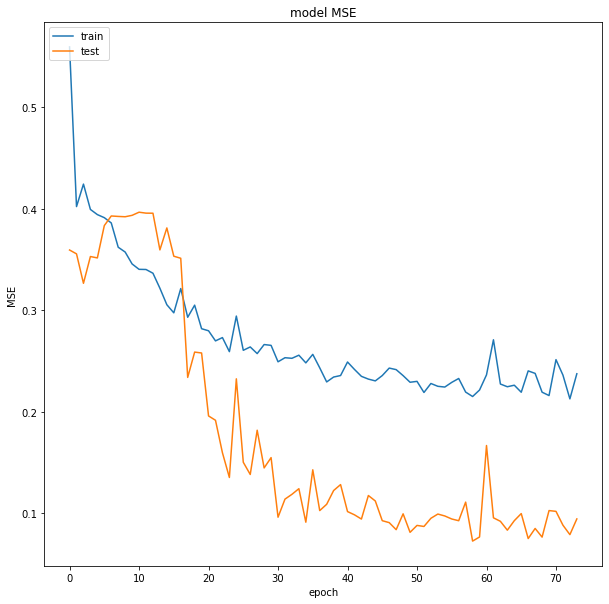

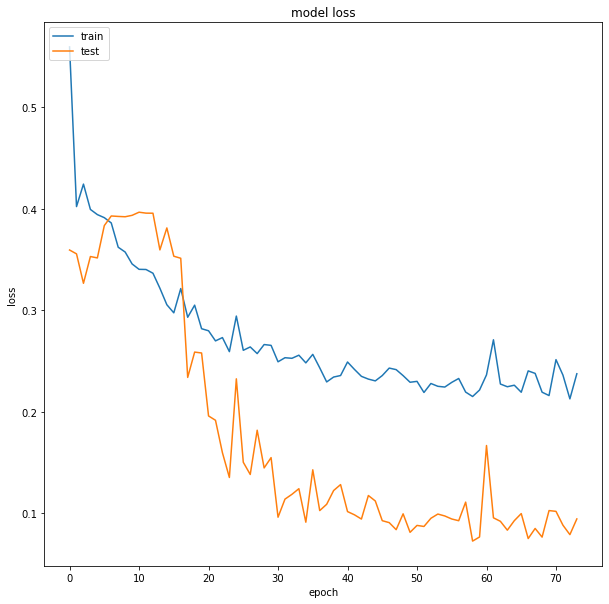

In [38]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

We can see great performance of our LSTM model during training.  The model MSE and loss reduces significantly with both the training and testing data, we also do not see the testing data loss get higher than the training data loss once its loss initially drops below the loss amount for the training data.

#### Model Validation

In order to validate our model, we will create a simulated "production" dataset.  This will mimic a streaming dataset, so any data sequences less than our defined sequence length will be padded with zeroes to ensure the correct sequence length is used until the number of readings streamed equal the defined sequence length.

In [39]:
# create arrays for validation dataset inputs and output
val_arrays = []
val_labs = []

# create list of temperature readings starting with a minimum of two readings
rlen = len(val_df) - ph
for end in range(2, rlen):
    if (end < seq_length):
        val_arrays.append(val_df[feat_cols][0:end].to_numpy())
        val_labs.append(val_df['Room_Occupancy_Count'][end+ph])
    # add sequences of defined seq_length once we have enough readings
    else:
        val_arrays.append(val_df[feat_cols][end-seq_length:end].to_numpy())
        val_labs.append(val_df['Room_Occupancy_Count'][end+ph])

# use pad_sequences function on input sequences, specify np.float32 to appease keras/tensorflow
val_arrays = pad_sequences(val_arrays, maxlen = seq_length, dtype = np.float32)

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

We will now run the validation data through our LSTM model and visualize the performance.

64/64 - 1s - loss: 9.3673 - mse: 9.3839 - 861ms/epoch - 13ms/step

MSE: 9.38388729095459
64/64 [==============================] - 1s 2ms/step


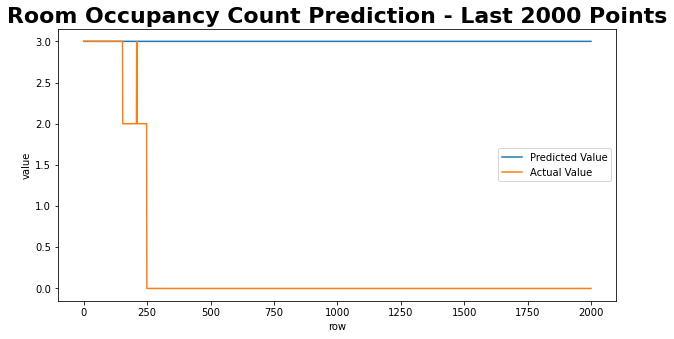

In [40]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_pred_test2 = np.floor(y_pred_test) # round down to nearest integer
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test2)
test_set.to_csv('submit_test.csv', index = None)

# plot the predicted data vs. the actual data
# we will limit our plot to the last 2000 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test2[-2000:], label = 'Predicted Value')
plt.plot(y_true_test[-2000:], label = 'Actual Value')
plt.title('Room Occupancy Count Prediction - Last 2000 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

Our validation did not perform as well as our previous test data.  Unfortunately, we believe this is, in part, because of the lack of sufficient data.  The majority of our validation data has 0 for the true value of Room Occupancy Count.  We can take a look at the breakdown of our output feature's actual values.

In [41]:
# print output feature value counts for both the original dataframe and validation dataframe
print ('Original Dataframe:\n',(df_raw.groupby(['Room_Occupancy_Count'])['Room_Occupancy_Count'].count()))
print ('\nValidation Dataframe:\n',(val_df.groupby(['Room_Occupancy_Count'])['Room_Occupancy_Count'].count()))

Original Dataframe:
 Room_Occupancy_Count
0    8228
1     459
2     748
3     694
Name: Room_Occupancy_Count, dtype: int64

Validation Dataframe:
 Room_Occupancy_Count
0    1751
2      93
3     182
Name: Room_Occupancy_Count, dtype: int64


We can see again see that the grand majority of output values are 0.  As noted during exploratory data analysis, the data was collected over a short timeframe of only seven days, including Christmas Eve and Christmas Day.  Presumably because of this, multiple days have 0 occupants recorded for the entire day.  For our validation dataset, we can see that there are no values of 1 occupant and only 275 values that were not 0, as compared to 1751 values which are 0.  We think our model would perform better with a larger dataset containing more occupancy activity.

### Task 1b - Deep Learning Model Prediction for Room Occupancy Count

#### Load and prepare data

#### Model Training

#### Model Validation

### Task 2 - Multiple Regression Model Prediction for CO2

#### Load and prepare data

#### Model Training

#### Model Validation

### Results/Conclusions